In [1]:
%load_ext dotenv
%reload_ext dotenv
%dotenv

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [4]:
import sys
import os
from os.path import dirname

UTILS_PATH=os.environ.get('REPO') + "/notebooks/commons"
sys.path.append(dirname(UTILS_PATH))

from commons import check_args, gen_paths
from commons import coordinates_bounds, plot_feature_importances
from commons import check_args_variables, gen_paths_variables

In [5]:
def load_posts(source_path, clean_path):
    external = pd.read_parquet(source_path)
    external.loc[:, "lat"] = external["lat"].apply(float)
    external.loc[:, "lon"] = external["lon"].apply(float)
    
    fincaraiz = pd.read_parquet(clean_path)
    return external, fincaraiz

In [6]:
if __name__ == "__main__":
    source = "OSM"
    city = "manizales"
    
    property_type = "apartamentos"
    post_type = "arriendo"
    
    base_path = os.environ.get('REPO')
    
    source_path = base_path + gen_paths_variables(source, city)
    raw_path, clean_path = gen_paths(city, property_type, post_type)
        
    raw_path = base_path + raw_path
    clean_path = base_path + clean_path

In [7]:
external_variables, fincaraiz = load_posts(source_path, clean_path)

In [8]:
from math import cos, asin, sqrt
def distance(lat1, lon1, lat2, lon2):
    """
    El resultado de la medición de distancia esta en kilometros.
    """
    p = 0.017453292519943295     #Pi/180
    a = 0.5 - cos((lat2 - lat1) * p)/2 + cos(lat1 * p) * cos(lat2 * p) * (1 - cos((lon2 - lon1) * p)) / 2
    return 12742 * asin(sqrt(a))

def post_to_place_distance(publications, places, index):
    publication = publications.loc[index]
    
    places_to_point = places.copy()
    places_to_point.loc[:, "fid"] = publication["fid"]
    
    places_to_point.loc[:, "latitide"] = publication["latitude"]
    places_to_point.loc[:, "longitude"] = publication["longitude"]
    
    places_to_point.loc[:, "distance"] = places_to_point.apply(
        lambda e: distance(publication["latitude"], publication["longitude"], e["lat"], e["lon"]), axis=1)
        
    return places_to_point

import functools
from multiprocessing import Pool
def get_near_points(external_variables, fincaraiz):    
    distance_map = functools.partial(
        post_to_place_distance, 
        fincaraiz, external_variables)
    
    pool = Pool(8)
    distances = pool.map(
        distance_map,
        fincaraiz.index
    )

    return pd.concat(distances).reset_index(drop=True)

In [9]:
distances_map = get_near_points(external_variables, fincaraiz)
distances_map.head()

,lat,lon,name,amenity,fid,latitide,longitude,distance
0,5.064422,-75.495189,CAI La Leonora,police,5469476,5.058869,-75.475807,2.233809
1,5.064628,-75.497428,101 Perros,fast_food,5469476,5.058869,-75.475807,2.478859
2,5.061315,-75.490434,Universidad de Caldas - Sede Palogrande,university,5469476,5.058869,-75.475807,1.642795
3,5.071657,-75.517147,None,marketplace,5469476,5.058869,-75.475807,4.794577
4,5.066886,-75.504299,Universidad Autónoma de Manizales,university,5469476,5.058869,-75.475807,3.279258


In [10]:
distances_map.loc[distances_map["distance"] == distances_map["distance"].min()]

,lat,lon,name,amenity,fid,latitide,longitude,distance
265282,5.033707,-75.468955,Estacion De Servicio San Marcel,fuel,4628153,5.033705,-75.468948,0.000825


In [11]:
## Un punto de interes es cercano a la publicicación cuando esta a menos de 3 kilometros

near_points = distances_map.loc[distances_map["distance"] < 3]
near_points.head()

,lat,lon,name,amenity,fid,latitide,longitude,distance
0,5.064422,-75.495189,CAI La Leonora,police,5469476,5.058869,-75.475807,2.233809
1,5.064628,-75.497428,101 Perros,fast_food,5469476,5.058869,-75.475807,2.478859
2,5.061315,-75.490434,Universidad de Caldas - Sede Palogrande,university,5469476,5.058869,-75.475807,1.642795
5,5.063438,-75.499609,Universidad de Caldas - Facultad de Ciencias p...,university,5469476,5.058869,-75.475807,2.684830
6,5.062827,-75.497807,Clínica Versalles,hospital,5469476,5.058869,-75.475807,2.476115


In [12]:
near_points.describe()

,lat,lon,latitide,longitude,distance
count,408011.000000,408011.000000,408011.000000,408011.000000,408011.000000
mean,5.059699,-75.500736,5.059971,-75.497980,1.596016
std,0.008784,0.014269,0.009024,0.014210,0.802294
min,5.017551,-75.554942,5.018835,-75.547905,0.000825
25%,5.055390,-75.513487,5.052965,-75.507553,0.920843
50%,5.061689,-75.499311,5.061800,-75.496140,1.584419
75%,5.067142,-75.488389,5.065619,-75.487251,2.290621
max,5.096118,-75.445525,5.093038,-75.448296,2.999964


In [13]:
near_points_by_categories = near_points[["fid", "amenity", "name"]].groupby(["fid", "amenity"]).count()
near_points_by_categories.head()

name
fid     amenity              
2450401 atm                 0
        bank               18
        bar                10
        bench               0
        bicycle_parking     0

In [14]:
index = list(zip(*near_points_by_categories.index))
near_points_by_categories.loc[:, "fid"] = index[0]
near_points_by_categories.loc[:, "amenity"] = index[1]
near_points_by_categories.loc[:, "count"] = near_points_by_categories["name"]

near_points_by_categories = near_points_by_categories.reset_index(drop=True)
near_points_by_categories = near_points_by_categories.drop(["name"], axis=1)
near_points_by_categories.head()

,fid,amenity,count
0,2450401,atm,0
1,2450401,bank,18
2,2450401,bar,10
3,2450401,bench,0
4,2450401,bicycle_parking,0


In [15]:
posts_full = fincaraiz[["fid"]].copy()
posts_full = posts_full.drop_duplicates(["fid"])

def safe_get(post, amenity):
    client = near_points_by_categories.loc[
        near_points_by_categories["fid"] == post["fid"]]
    
    if client.shape[0] == 0:
        return 0
    
    client = client.loc[client["amenity"] == amenity]
    if client.shape[0] == 0:
        return 0
    
    return client["count"].iloc[0]

In [16]:
for amenity in external_variables["amenity"].value_counts().index:
    posts_full.loc[:, amenity] = posts_full.apply(lambda e: safe_get(e, amenity), axis=1)

In [18]:
## Las features y las etiquetas son las mismas en todos los métodos

FEATURES = list(filter(lambda e: e != "fid", posts_full.columns))
LABEL = "price"

final_features = pd.merge(posts_full, fincaraiz[["fid", "price"]], on="fid")

X = final_features[FEATURES].values
y = final_features[LABEL].values

## Selección de features univariada

In [19]:
selector = SelectKBest(f_regression, k=5)
X_new = selector.fit_transform(X, y)
X_new.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


(1027, 5)

In [20]:
feature_importances = pd.DataFrame({'importance': selector.scores_, 'feature': FEATURES})

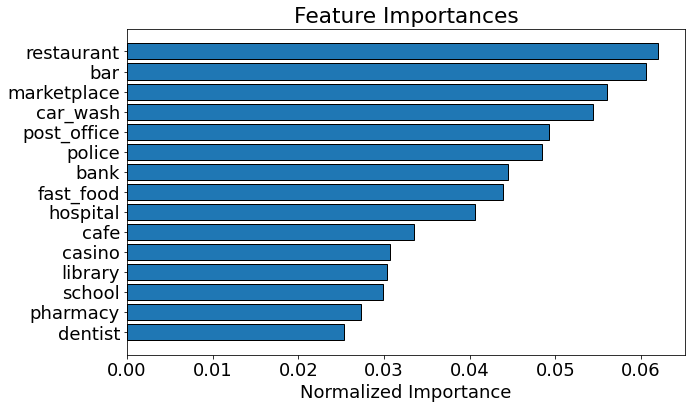

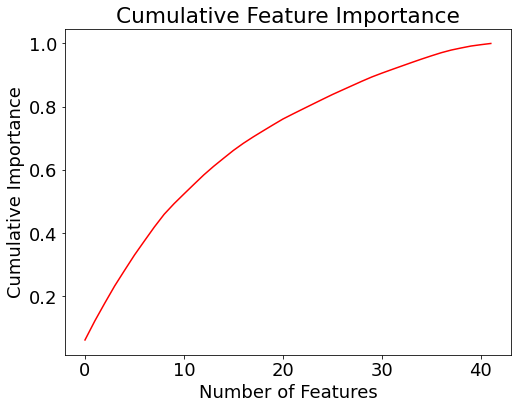

31 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,2,3.043215,restaurant,0.062017,0.062017
1,12,2.973206,bar,0.060591,0.122608
2,41,2.750201,marketplace,0.056046,0.178654
3,20,2.667449,car_wash,0.054360,0.233014
4,13,2.419256,post_office,0.049302,0.282316
5,25,2.376921,police,0.048439,0.330755
6,5,2.180778,bank,0.044442,0.375197
7,4,2.152317,fast_food,0.043862,0.419059
8,16,1.992436,hospital,0.040604,0.459662
9,15,1.645913,cafe,0.033542,0.493204


In [21]:
plot_feature_importances(feature_importances)

## Eliminación recursiva de features

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [23]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.02354589840149901

In [24]:
rfe = RFE(estimator=reg, n_features_to_select=1, step=1)
rfe.fit(X, y)

RFE(estimator=LinearRegression(), n_features_to_select=1)

In [25]:
feature_importances = pd.DataFrame({'importance': rfe.ranking_, 'feature': FEATURES})

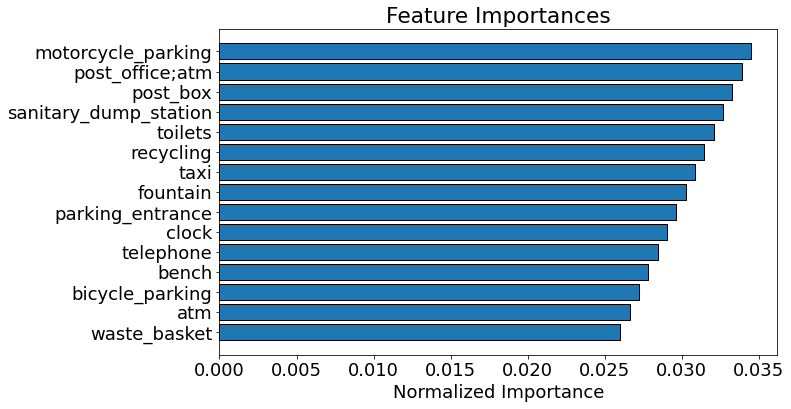

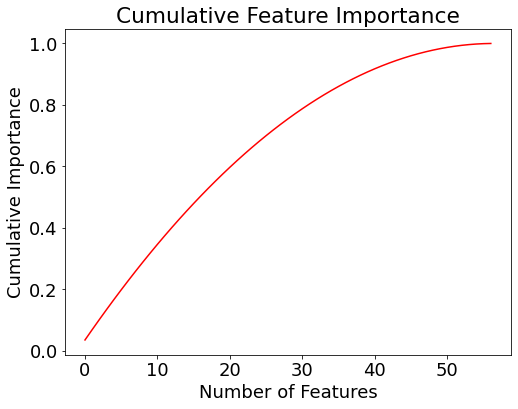

40 features required for 0.90 of cumulative importance


,index,importance,feature,importance_normalized,cumulative_importance
0,56,57,motorcycle_parking,0.034483,0.034483
1,50,56,post_office;atm,0.033878,0.068361
2,45,55,post_box,0.033273,0.101633
3,43,54,sanitary_dump_station,0.032668,0.134301
4,22,53,toilets,0.032063,0.166364
5,40,52,recycling,0.031458,0.197822
6,29,51,taxi,0.030853,0.228675
7,19,50,fountain,0.030248,0.258923
8,17,49,parking_entrance,0.029643,0.288566
9,24,48,clock,0.029038,0.317604


In [ ]:
plot_feature_importances(feature_importances)

## Selección de features basada en arboles

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

In [ ]:
forest = ExtraTreesRegressor(n_estimators=100, random_state=0)
forest.fit(X, y)

In [ ]:
feature_importances = pd.DataFrame({'importance':  forest.feature_importances_, 'feature': FEATURES})

In [ ]:
plot_feature_importances(feature_importances)